# Finding Similar Shoes Using Vector Search in Db2

## Prepare DB2

Ensure DB2 is up and running.  The following commands in the DB2 container should help:

```bash
su - db2inst1
export PATH=/opt/ibm/db2/V12.1/bin:$PATH
db2start
db2 create database testdb
db2 list database directory
```

In [1]:
import pandas as pd
import os
from dotenv import dotenv_values, load_dotenv
from ibm_watsonx_ai import APIClient, Credentials
from ibm_watsonx_ai.foundation_models import Embeddings
#from IPython.display import Image, display
#import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE
#import numpy as np
#import ast
#import matplotlib.image as mpimg
from utils import *
#from typing import List, Tuple, Any
import ibm_db
#import ibm_db_dbi as dbi

pd.set_option('display.max_colwidth', None)  # Show full column content

# Enable Db2 Magic Commands Extensions for Jupyter Notebook
if not os.path.isfile('db2.ipynb'):
    os.system('wget https://raw.githubusercontent.com/IBM/db2-jupyter/master/db2.ipynb')


%run db2.ipynb

Db2 Extensions Loaded. Version: 2024-09-16


<>:1708: SyntaxWarning: invalid escape sequence '\s'
<>:2305: SyntaxWarning: invalid escape sequence '\?'
/tmp/ipykernel_2178/2299624180.py:1708: SyntaxWarning: invalid escape sequence '\s'
  firstCommand = "(?:^\s*)([a-zA-Z]+)(?:\s+.*|$)"
/tmp/ipykernel_2178/2299624180.py:2305: SyntaxWarning: invalid escape sequence '\?'
  pattern = "\?\*[0-9]+"


## Setting up wx.ai API for embedding generation

In [2]:
load_dotenv(os.getcwd()+"/.env", override=True)

#credentials = Credentials(
#                url = "https://us-south.ml.cloud.ibm.com",
#                api_key = os.getenv("WATSONX_APIKEY", "")
#                )
#
#client = APIClient(credentials)
#
#project_id = os.getenv("WATSONX_PROJECT", "")
#client.set.default_project(project_id)
#
#embeddings = Embeddings(
#    model_id=client.foundation_models.EmbeddingModels.MULTILINGUAL_E5_LARGE,
#    credentials=credentials,
#    project_id=project_id,
#)

True

## Setting up Db2 Connection

In [3]:
db2creds = dotenv_values('.env')
db2creds


OrderedDict([('WATSONX_PROJECT', ''),
             ('WATSONX_APIKEY', ''),
             ('database', 'testdb'),
             ('hostname', 'db.dns.podman'),
             ('port', '50000'),
             ('protocol', 'tcpip'),
             ('uid', 'db2inst1'),
             ('pwd', 'password')])

In [4]:
%sql CONNECT CREDENTIALS db2creds

Connection successful. testdb @ db.dns.podman 


# Setting up a Shoes Table at Db2

In [5]:
%sql DROP TABLE SQ_SHOES

# Create the table
sql = get_create_sq_shoes_table_sql()
%sql {sql}

Command completed.
Command completed.


In [6]:
#%%capture output
#sql = f'''"IMPORT FROM 'shoes-vectors.csv' OF DEL skipcount 1 INSERT INTO SQ_SHOES"'''
_ = ! db2 "connect to testdb"

#output = %system db2 {sql}
#print(output)

In [7]:
shoes = pd.read_csv('shoes.csv')
#shoes['EMBEDDING'] = shoes['EMBEDDING'].apply(json.loads)
print(shoes)

          SKU            PRODUCT_NAME      BRAND  CLASS     TYPE   MATERIAL  \
0    ZEN-5999       Zentrax X Walking    Zentrax  Women  Walking  Synthetic   
1    RUN-4723   RunXpress Max Walking  RunXpress  Women  Walking  Synthetic   
2    ZEN-8968     Zentrax Pro Running    Zentrax    Men  Running  Synthetic   
3    RUN-7569     RunXpress X Walking  RunXpress    Men  Walking  Synthetic   
4    RUN-1083     RunXpress X Walking  RunXpress  Women  Walking  Synthetic   
..        ...                     ...        ...    ...      ...        ...   
495  ZEN-7398       Zentrax X Walking    Zentrax    Men  Walking       Knit   
496  ZEN-4049    Zentrax Flex Running    Zentrax    Men  Running  Synthetic   
497  RUN-6703  RunXpress Flex Running  RunXpress  Women  Running  Synthetic   
498  ZEN-2650     Zentrax Max Running    Zentrax  Women  Running  Synthetic   
499  RUN-3313     RunXpress X Walking  RunXpress  Women  Walking  Synthetic   

     COLOR WEATHER_RESISTANCE ARCH_SUPPORT  SIZE   

In [9]:
connection = f"DATABASE={os.getenv('database')};HOSTNAME={os.getenv('hostname')};PORT={os.getenv('port')};PROTOCOL=TCPIP;UID={os.getenv('uid')};PWD={os.getenv('pwd')};"
conn = ibm_db.connect(connection, "", "")

sql_insert = "INSERT INTO SQ_SHOES(SKU,PRODUCT_NAME,BRAND,CLASS,TYPE,MATERIAL,COLOR,WEATHER_RESISTANCE,ARCH_SUPPORT,SIZE,PRICE,RATING,STORE_ID,CITY) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?)"

preparedStmt = None
try:
    preparedStmt = ibm_db.prepare(conn, sql_insert)
except Exception:
    print(Exception.tostring())
  
if preparedStmt is False:
    print("\nERROR: Unable to prepare the SQL statement specified.\n")
    ibm_db.close(conn)
else:
  tuple_of_tuples = tuple([tuple(x) for x in shoes.values])
  print(tuple_of_tuples)

try:
  ibm_db.execute_many(preparedStmt, tuple(tuple_of_tuples))
except Exception:
  print(Exception)
  
ibm_db.close(conn)

  


(('ZEN-5999', 'Zentrax X Walking', 'Zentrax', 'Women', 'Walking', 'Synthetic', 'White', 'Resistant', 'High', 8.0, 108.65, 4.3, 1.0, 'Ottawa'), ('RUN-4723', 'RunXpress Max Walking', 'RunXpress', 'Women', 'Walking', 'Synthetic', 'White', 'Waterproof', 'High', 8.5, 103.22, 3.0, 20.0, 'Ottawa'), ('ZEN-8968', 'Zentrax Pro Running', 'Zentrax', 'Men', 'Running', 'Synthetic', 'Black', 'Waterproof', 'High', 7.5, 100.25, 3.7, 13.0, 'Toronto'), ('RUN-7569', 'RunXpress X Walking', 'RunXpress', 'Men', 'Walking', 'Synthetic', 'Black', 'Waterproof', 'Flat', 7.5, 83.84, 3.2, 4.0, 'Ottawa'), ('RUN-1083', 'RunXpress X Walking', 'RunXpress', 'Women', 'Walking', 'Synthetic', 'Black', 'Resistant', 'Flat', 12.5, 139.7, 3.8, 2.0, 'Toronto'), ('LOO-1505', 'Loopic X Walking', 'Loopic', 'Men', 'Walking', 'Synthetic', 'White', 'Resistant', 'High', 11.5, 115.43, 3.7, 5.0, 'Toronto'), ('LOO-7876', 'Loopic Flex Walking', 'Loopic', 'Men', 'Walking', 'Knit', 'White', 'Resistant', 'Flat', 11.0, 45.42, 4.6, 6.0, 'Toron

True

## Searching for a Running Shoe of Size `12`, for `Men`

In [11]:
%sql SELECT count(*) FROM SQ_SHOES

,1
0,500


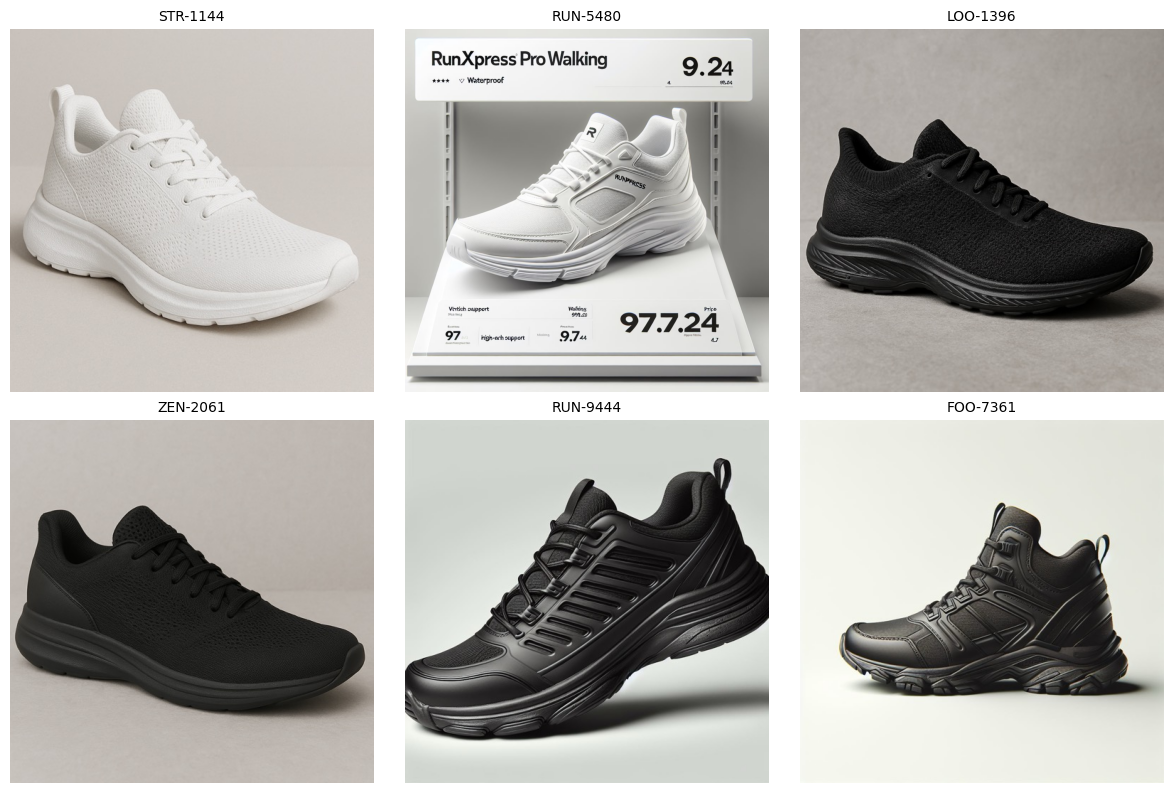

,SKU,PRODUCT_NAME,BRAND,TYPE,MATERIAL,COLOR,WEATHER_RESISTANCE,ARCH_SUPPORT,PRICE,RATING,CITY
0,STR-1144,StrideOne Max Running,StrideOne,Running,Knit,White,Waterproof,High,98.13,3.4,Ottawa
1,RUN-5480,RunXpress Pro Walking,RunXpress,Walking,Knit,White,Waterproof,High,97.24,4.7,Toronto
2,LOO-1396,Loopic Pro Running,Loopic,Running,Knit,Black,Resistant,Flat,43.98,4.6,Toronto
3,ZEN-2061,Zentrax Flex Running,Zentrax,Running,Knit,Black,Waterproof,Flat,134.65,4.9,Ottawa
4,RUN-9444,RunXpress X Running,RunXpress,Running,Synthetic,Black,Waterproof,Flat,106.10,3.6,Ottawa
5,FOO-7361,FootFlex Pro Running,FootFlex,Running,Synthetic,Black,Waterproof,High,83.21,4.8,Ottawa


In [12]:
sql = get_men_shoes_sql()
df_shoe_search = %sql {sql}

sku_list = df_shoe_search['SKU'].tolist()
display_sku_images(sku_list)

df_shoe_search.head(6)

### My chosen shoe is available at the Ottawa location

In [13]:
my_choice_sku = 'ZEN-2061'

## Searching for a similar shoes at the Toronto Location

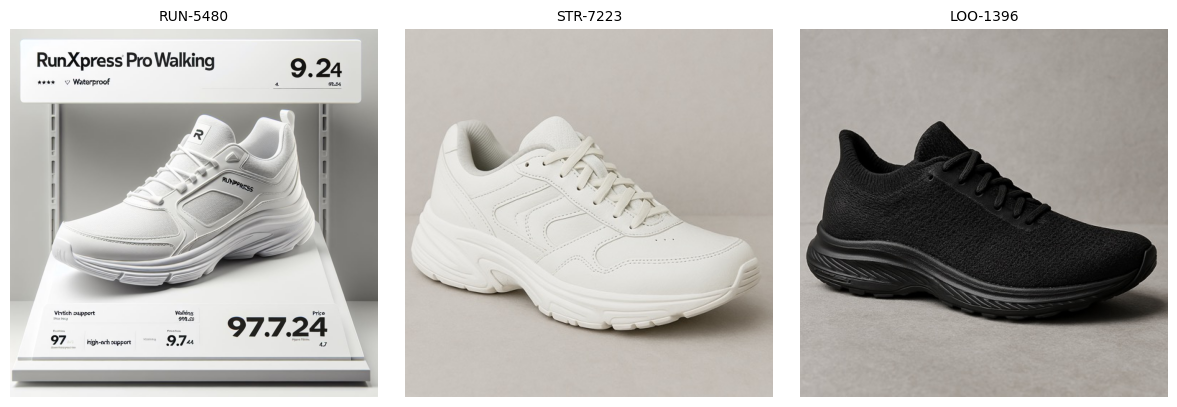

,SKU,PRODUCT_NAME,BRAND,TYPE,MATERIAL,COLOR,WEATHER_RESISTANCE,ARCH_SUPPORT,PRICE,RATING,DISTANCE
0,RUN-5480,RunXpress Pro Walking,RunXpress,Walking,Knit,White,Waterproof,High,97.24,4.7,NaN
1,STR-7223,StrideOne Max Walking,StrideOne,Walking,Synthetic,White,Resistant,High,130.03,3.9,NaN
2,LOO-1396,Loopic Pro Running,Loopic,Running,Knit,Black,Resistant,Flat,43.98,4.6,NaN


In [14]:
sql = get_similar_shoes_sql()
df_shoes_results = %sql {sql}
sku_list = df_shoes_results['SKU'].tolist()

display_sku_images(sku_list)
df_shoes_results.head(3)

## Comparing the Search Results with my Preferred Shoe

In [15]:
sku_list = df_shoes_results.iloc[[0, 2]]['SKU'].tolist()
sku_list.append(my_choice_sku)

sku_sql_in = ', '.join(f"'{sku}'" for sku in sku_list)

sql = get_distance_for_sku_list_sql(sku_sql_in)

df_result = %sql {sql}

cols_show = ['SKU', 'TYPE', 'MATERIAL', 'COLOR', 'WEATHER_RESISTANCE', 'ARCH_SUPPORT']
df_result[cols_show].transpose()

,0,1,2
SKU,RUN-5480,LOO-1396,ZEN-2061
TYPE,Walking,Running,Running
MATERIAL,Knit,Knit,Knit
COLOR,White,Black,Black
WEATHER_RESISTANCE,Waterproof,Resistant,Waterproof
ARCH_SUPPORT,High,Flat,Flat


## Looking under the hood

### 1. original table without a `VECTOR` column

In [ ]:
%sql DROP TABLE SQ_SHOES

# Create the table
sql = get_create_sq_shoes_table_data_only()
%sql {sql}

sql = f'''"IMPORT FROM 'shoes.csv' OF DEL skipcount 1 INSERT INTO SQ_SHOES"'''
_ = ! db2 "connect to TPCDS"

output = %system db2 {sql}

%sql SELECT * FROM SQ_SHOES FETCH FIRST 3 ROWS ONLY

### 2. Adding a `VECTOR` column

In [ ]:
%%sql
ALTER TABLE SQ_SHOES
ADD COLUMN EMBEDDING VECTOR(1024, FLOAT32);

In [ ]:
sql = f'''"DESCRIBE TABLE SQ_SHOES"'''
_ = ! db2 "connect to TPCDS"

%system db2 {sql}

In [ ]:
%sql SELECT * FROM SQ_SHOES FETCH FIRST 3 ROWS ONLY

### 1. selected shoe features for generating shoe vectors

In [ ]:
embedding_cols = ['TYPE', 'MATERIAL', 'COLOR', 'WEATHER_RESISTANCE', 'ARCH_SUPPORT']
shoe_sample = %sql SELECT * FROM SQ_SHOES WHERE SKU = :my_choice_sku
shoe_sample[embedding_cols]

### 2. combined the text features of each shoe as follows

In [ ]:
# Combine all columns into a single string for each row, including column names
shoe_sample['combined'] = shoe_sample.apply(
    lambda row: ' [SEP] '.join([f"{col_name}: {row[col_name]}" for col_name in embedding_cols]), 
    axis=1
)

shoe_sample.iloc[0]['combined']

### 3. generated embedding vectors for the shoe text obtained in the previous step. For generating embedding vectors, used `watsonx.ai`

In [ ]:

row_combined = shoe_sample['combined'].tolist()
print('input text: ', row_combined[0])

shoe_vectors = embeddings.embed_documents(texts=row_combined)
print('generated embedding vector: ', shoe_vectors[0])

shoe_sample['embedding'] = shoe_vectors
shoe_sample['embedding'] = shoe_sample['embedding'].apply(lambda x: '[' + ', '.join(map(str, x)) + ']')

### 4. stored vectors in Db2 in a Vector column

In [ ]:
%sql SELECT EMBEDDING FROM SQ_SHOES WHERE SKU = :my_choice_sku

In [ ]:
update_sql = f""" 
UPDATE SQ_SHOES SET EMBEDDING = VECTOR('{shoe_vectors[0]}', 1024, FLOAT32) WHERE SKU = :my_choice_sku
"""

%sql {update_sql}

In [ ]:
%sql SELECT EMBEDDING FROM SQ_SHOES WHERE SKU = :my_choice_sku

### 5. Loading the vectors of all the shoes - to save demo time

In [ ]:
%sql DROP TABLE SQ_SHOES

# Create the table
sql = get_create_sq_shoes_table_sql()
%sql {sql}

sql = f'''"IMPORT FROM 'shoes-vectors.csv' OF DEL skipcount 1 INSERT INTO SQ_SHOES"'''
_ = ! db2 "connect to TPCDS"

output = %system db2 {sql}

### 6. Finding matching shoes using the `VECTOR_DISTANCE` function

In [ ]:
sql = f"""
SELECT 
    SKU, 
    PRODUCT_NAME, 
    BRAND, 
    TYPE, 
    MATERIAL, 
    COLOR, 
    WEATHER_RESISTANCE, 
    ARCH_SUPPORT, 
    PRICE, 
    RATING,
    VECTOR_DISTANCE(
        (SELECT EMBEDDING FROM SQ_SHOES WHERE SKU = :my_choice_sku), 
        EMBEDDING, 
        EUCLIDEAN
    ) AS DISTANCE
FROM 
    SQ_SHOES
WHERE 
    SKU <> :my_choice_sku
    AND CITY = 'Toronto'
    AND SIZE = 12
    AND CLASS = 'Men'
ORDER BY 
    DISTANCE ASC
FETCH FIRST 5 ROWS ONLY
"""

top_shoes = %sql {sql}
top_shoes.head()

### 7. Visualizing vector search

In [ ]:

sku_list = top_shoes['SKU'].tolist()
sku_list.append(my_choice_sku)
sku_sql_in = ', '.join(f"'{sku}'" for sku in sku_list)
sql = get_similarity_query(sku_sql_in)

top_matching_vectors = %sql {sql}

plot_similarity_tsne(top_matching_vectors, my_choice_sku)

In [ ]:
%sql DROP TABLE SQ_SHOES

In [ ]:
%sql CONNECT RESET